# Exploring outbreaks in India using geopandas

## Outline

In this notebook, the outbreaks of different diseases in India will be explored. Outbreak data by district is merged with the geospatial information of each district to map outbreaks. Furthermore the time evolution of outbreaks can also be mapped.


## Background

Disease outbreak data for India was downloaded from the [Integrated Disease Surveillance Program](https://idsp.nic.in/) in the form of weekly reports in .pdf format. The dataset spans 2009 to present day and is extracted from the .pdf files using `idsp_parser.py`. It is then merged with district data from [Global Administrative Area Maps](https://gadm.org) to form a _master_ geopandas dataframe which has all the information for plotting.

In [16]:
import geopandas as gpd
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import scipy as sp
from datetime import datetime
import shapely as sh
from fuzzywuzzy import fuzz
from tqdm import tqdm
import re

%matplotlib notebook

# Cleaning up the data

The IDSP_parser.py program returns a .csv file of outbreaks. However, further processing is required to clean the dataset. These steps are:

* Consolidate duplicated reporting
* Convert string columns to numeric, datetime and other datatypes
* Merging outbreak DataFrame with GeoDataFrame to connect the outbreak data with geospatial information

After these basic steps are complete, then the data can be queried and plotted.

In [17]:
def fuzzy_match(hypotheses, target, thresh=5):
    # returns the hypothesis which best matches the target
    match = []

    # build a list of (score, state) tuples
    for h in hypotheses:
        match.append((fuzz.token_sort_ratio(h,target), h))

    # sort the list of tuples to take the state with highest score
    match.sort()
    
    if match[-1][0] >= thresh:
        return match[-1][-1]
    elif thresh == None:
        return match[-1]


Lets explore these datasets. _outbreaks_ has text information regarding outbreaks; when, where, what, how many and current status. There is also a comments field which contains potentially useful but unstructured data.

In [18]:
df = pd.read_csv("idsp_database.csv")
shps_GADM_v2 = gpd.read_file('/users/rsg/anla/podcast/country_district_shape_files/INDIA/GADM_IND_v2/IND_adm3.shp')
shps_GADM_v3 = gpd.read_file('/users/rsg/anla/podcast/country_district_shape_files/INDIA/GADM_IND_v3/gadm36_IND_3.shp')
shps_2011 = gpd.read_file("2011_Dist.shp")
shps_2011 = shps_2011.rename(columns={'DISTRICT':'district','ST_NM':'state'})

In [19]:
set(df.disease_illness)

{'Acute Diarrheal Disease',
 'Acute Encephalitis Syndrome',
 'Acute Flaccid Paralysis',
 'Acute Respiratory Infection',
 'Bacillary Dysentery',
 'Chicken Pox',
 'Chikungunya',
 'Cholera',
 'Dengue',
 'Diphtheria',
 'Dog Bite',
 'Enteric Fever',
 'Food Poisoning',
 'Leptospirosis',
 'Malaria',
 'Measles',
 'Pertussis',
 'Typhoid',
 'Viral Hepatitis',
 nan}

In [5]:
print('we have detected {} outbreaks'.format(df.shape[0]))

we have detected 18160 outbreaks


Lets check how many outbreak records match sub district level names.

In [6]:
len(list(set(df.district).intersection(set(shps_GADM_v3.NAME_3))))

422

140 is a lot fo matches, especially since this is a strict match. It should be noted that subdistricts often share the name with the district itself. How many outbreak records match by district. Many of these will be shared with the sub district level count.

In [7]:
len(list(set(df.district).intersection(set(shps_GADM_v3.NAME_2))))

559

How many match sub-district and do not match district.

In [8]:
set(df.district).intersection(set(shps_GADM_v3.NAME_3)).difference(set(df.district).intersection(set(shps_GADM_v3.NAME_2)))

{'Agar',
 'Agartala',
 'Balurghat',
 'Bara Banki',
 'Bareli',
 'Basirhat',
 'Bhubaneshwar',
 'Chevella',
 'Cuddapah',
 'Davangere',
 'Delhi',
 'Deogarh',
 'Diamond Harbour',
 'Gangtok',
 'Gondia',
 'Gundlupet',
 'Haridwar',
 'Jagatsinghpur',
 'Jahanabad',
 'Janjgir',
 'Kamareddy',
 'Kanchipuram',
 'Kangpokpi',
 'Kanker',
 'Kanpur',
 'Kawardha',
 'Khandwa',
 'Khargon',
 'Kollegal',
 'Lawngtlai',
 'Mangalore',
 'Medchal',
 'Medinipur',
 'Narnaul',
 'Nimach',
 'Nirmal',
 'Nuh',
 'Pauri',
 'Sibsagar',
 'Silvassa',
 'Tehri',
 'Tengnoupal',
 'Tezu',
 'Tiruvallur',
 'Trichur',
 'Trivandrum',
 'Tuticorin',
 'Vikarabad',
 'Vishakhapatnam'}

These are predominantly cities and represent a significant number of records that we can capture by checking against sub-district levels data as each of these in principle correspond to many different outbreaks.

We should first check districts against level 3, then level 2, superceeding the first match if the district matches level 2. These check are direct comparisons.

States are then matched. If the state is missing, which does occur, then the state should be inferred by the district. However, some districts from different states have the exact same name, in that case the state should not be assumed in the same manner. Instead, after the states are inferred in this way, the remaining missing states can be filled using ffill() or bfill() methods.

The first round of direct matching of states and districts should be followed up by a fuzzy matching round. Which matches similar strings. In order to the data to be auditable, the match score and original district should be recorded in new columns

```
df['district'] ---> df[['district','district_score','original_district']]
```



In [9]:
shps_GADM_v3.NAME_1 = shps_GADM_v3.NAME_1.apply(lambda x:x.title())
shps_GADM_v3.NAME_2 = shps_GADM_v3.NAME_2.apply(lambda x:x.title())
shps_GADM_v3.NAME_3 = shps_GADM_v3.NAME_3.apply(lambda x:x.title())

In [10]:
# create empty columns for filling with level names
df['NAME_1'] = None
df['NAME_2'] = None
df['NAME_3'] = None

## Primary direct matching

In [11]:
# First check for direct matches,
# at sub-district, district and state levels

for i, row in df.iterrows():
    
    # sub district level
    if row.district in set(shps_GADM_v3.NAME_3):
        temp = shps_GADM_v3[shps_GADM_v3.NAME_3 == row.district].iloc[0]
        df.at[i,'NAME_2'] = temp['NAME_2']
        df.at[i,'NAME_3'] = temp['NAME_3']
        
    # superceed at district level
    if row.district in set(shps_GADM_v3.NAME_2):
        df.at[i,'NAME_2'] = row.district
        df.at[i,'NAME_3'] = None
    
    # match states
    if row.state in set(shps_GADM_v3.NAME_1):
        temp = shps_GADM_v3[shps_GADM_v3.NAME_2 == row.state]
        df.at[i,'NAME_1'] = row.state

## Secondary fuzzy matching

This process depends on the threshold. Low threshold increases true and false positive rates, low threshold deceases true and false positive rates.

In [12]:
# Fuzzy matching to get the different spellings of same place
# For example, Yadgiri --> Yadgir
# Default threshold for a match is 95 out of 100
for i, row in tqdm(df.iterrows()):
    
    # sub district level
    
    if row.NAME_3 == None:
#         print('# SUB DISTRICT:')
        match = fuzzy_match(shps_GADM_v3.NAME_3, 
                            row.district,
                            thresh=90)
#         print(row.district,'---->',match)
        df.at[i,'NAME_3'] = match
        
    # district level
    if row.NAME_2 == None:
#         print('# DISTRICT:')
        match = fuzzy_match(list(set(shps_GADM_v3.NAME_2)), 
                            row.district,
                            thresh=90)
#         print(row.district,'---->',match)
        df.at[i,'NAME_2'] = match
        df.at[i,'NAME_3'] = None

    # state level
    if row.NAME_1 == None:
#         print('# STATE:')
        match = fuzzy_match(list(set(shps_GADM_v3.NAME_1)), 
                            row.state,
                            thresh=90)
#         print(row.state,'---->',match)
        df.at[i,'NAME_1'] = match

18160it [06:11, 48.88it/s]


In [13]:
df.comment_action_taken[0]

'Cases reported from  Village  Ward  no  28, Musahari tola.  District  RRT investigated the outbreak.  House to  house survey  done.  All cases treated symptomatically. Health education given.'

In [14]:
df.NAME_2.count()

13316

# Merge with geospatial

<IPython.core.display.Javascript object>


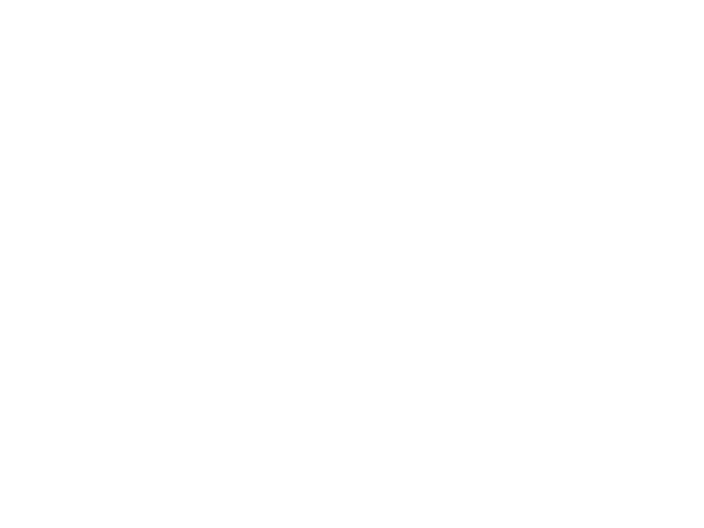

TypeError: '<' not supported between instances of 'str' and 'float'

In [15]:
# Plot the number of cases of outbreaks
# localised to a sub-district

shps_GADM_v3.merge(df, on=['NAME_1','NAME_2','NAME_3']).plot(column='num_cases',
                                                             cmap='Reds'
                                                            )

In [ ]:
df.date_of_reporting.fillna('')

for i, row in df.iterrows():
    try:
        # split cases / deaths column
        # use regex to extract digits
#         cases, deaths = row.num_cases.split('/')
        cases, deaths = re.findall('\d+',row.num_cases)
        # shuffle right dates to correct columns
        date_outbreak = row.num_deaths
        date_reporting = row.date_of_start_of_outbreak

        for j, var in enumerate(['num_cases',
                    'num_deaths',
                    'date_of_start_of_outbreak',
                    'date_of_reporting'
                   ]):
            df.at[i,var] = [int(cases),int(deaths),date_outbreak,date_reporting][j]
    except:
        pass

# set columns to type integer
def extract_digits(x):
    try:
        return re.findall('\d+',x)[0]
    except:
        return x

df[['num_cases','num_deaths']] = df[['num_cases','num_deaths']].apply(extract_digits)

In [ ]:
# Plot the number of cases of outbreaks
# localised to a district

district_level = shps_GADM_v3.dissolve(by=['NAME_1','NAME_2'])

In [ ]:
district_level = district_level.merge(df, on=['NAME_1','NAME_2'])

In [ ]:
district_level.num_cases = pd.to_numeric(district_level.num_cases, errors='coerce')

In [ ]:
district_level = district_level.dissolve(by=['disease_illness','NAME_1','NAME_2'], aggfunc='sum')

In [ ]:
district_level.loc['Cholera']

In [ ]:
district_level.plot(column='num_cases',cmap='Blues',vmax=1000)

# `### TAIL OF CURRENT WORKFLOW ###`

In [30]:
df.num_cases

0       05
1       12
2       07
3       06
4       12
      ... 
429    113
430     35
431     35
432     22
433     19
Name: num_cases, Length: 434, dtype: object

In [ ]:

# for backfilling missing state values from the district
district_state_dict = {}
for d in shps_2011[['state','district']].values:
    district_state_dict[d[1]] = d[0]

print('census 2011 districts')
district_names = set(shps.district); print(len(district_names))
print('census 2011 state')
state_names = set(shps.state); print(len(state_names))

print('df districts')
print(len(list(set(df.district))))

with open('disease_names.txt','r') as f:
    disease_names = f.read().split('\n')

In [ ]:
set(df.title)

In [ ]:
district_names = list(district_names)
district_names.sort()

In [ ]:
df_dist = [str(a) for a in list(set(df.district))]
df_dist.sort()
df_dist

In [ ]:
df.date_of_reporting.fillna('')

for i, row in df.iterrows():
    
    match = fuzzy_match(district_names, row.district)
    
    if match[-1] >= 85:
        df.at[i, 'district'] = match[0]

In [ ]:
len(list(set(df.district)))

In [ ]:
district_matches = []
for d in list(set(df.district.dropna())):
    district_matches.append((fuzzy_match(district_names, d)[::-1],d))
    print(d,'--->',fuzzy_match(district_names, d))

In [ ]:
district_matches.sort()
district_matches

In [ ]:
[a[0][0] for a in district_matches].index(69)

In [ ]:
plt.figure()
plt.ylabel('fuzzy match score')
plt.xlabel('record')
plt.plot([a[0][0] for a in district_matches])
plt.show()

## Fuzzy match state + district...

In [ ]:
state_district = []
for key in district_state_dict.keys():
    state_district.append(' '.join((district_state_dict[key],key)))
    
state_district.sort()

In [ ]:
sd_matches = []
for sd in (df.state.ffill() + ' ' + df.district).dropna():
    print(sd ,' ----> ',fuzzy_match(state_district, sd))
    sd_matches.append((fuzzy_match(state_district, sd)[::-1],sd))


In [ ]:
sd_matches.sort()

In [ ]:
sd_matches[[a[0][0] for a in sd_matches].index(100)]

In [ ]:
sd_matches[1600]

In [ ]:
plt.figure()
plt.ylabel('fuzzy match score')
plt.xlabel('record')
plt.plot([a[0][0] for a in sd_matches])
plt.show()

## Convert to datetime

In [ ]:
df.columns

In [ ]:
from dateutil.parser import parse

In [ ]:
df['date_of_start_of_outbreak'].dropna().iloc[545]

Here we use a regex to extract pairs of digits. Followed by a pd.to_datetime call with coersion to return nan for invalid input

In [ ]:
df['date_of_start_of_outbreak'] = pd.to_datetime(
    df['date_of_start_of_outbreak'].dropna().apply(
        lambda x:'-'.join(re.findall("\d{2}|\d{4}",x))
    ),
    errors='coerce'
)

In [ ]:
df.date_of_start_of_outbreak

## Split case/death column to cases | deaths

Try to split num_cases by / if possible, put first value to num_cases and second to num_deaths, shifting cells right to put dates in their correct columns

In [ ]:
df.date_of_reporting.fillna('')

for i, row in df.iterrows():
    try:
        # split cases / deaths column
        # use regex to extract digits
#         cases, deaths = row.num_cases.split('/')
        cases, deaths = re.findall('\d+',row.num_cases)
        # shuffle right dates to correct columns
        date_outbreak = row.num_deaths
        date_reporting = row.date_of_start_of_outbreak

        for j, var in enumerate(['num_cases',
                    'num_deaths',
                    'date_of_start_of_outbreak',
                    'date_of_reporting'
                   ]):
            df.at[i,var] = [int(cases),int(deaths),date_outbreak,date_reporting][j]
    except:
        pass

print(df.num_cases)

In [ ]:
def extract_digits(x):
    try:
        return re.findall('\d+',x)[0]
    except:
        return x

df.num_cases = df.num_cases.apply(extract_digits)
df[['num_cases','num_deaths']] = df[['num_cases','num_deaths']].apply(lambda x:pd.to_numeric(x,errors='coerce')).dropna()


## Cast to numeric data

First get rid of the text data in the numeric columns of cases, deaths.

In [ ]:
df.num_cases.values

In [ ]:
def to_numeric_soft(x,y):
    # take a column in dataframe, find all digits
    # convert the column to numeric datatype and return
    return pd.to_numeric(x[y].apply(lambda x:re.findall('\d*',str(x))[0]))

In [ ]:
df.num_cases = to_numeric_soft(df,'num_cases')
df.num_deaths = to_numeric_soft(df,'num_deaths')

Now we can look at the total cases and deaths from Cholera in out dataset.

In [ ]:
total_cases, total_deaths = df[df.disease_illness == 'Cholera'].sum(axis=0)[['num_cases','num_deaths']].values
print(f'Total cases = {total_cases},\ndeaths = {total_deaths},\nmortality rate = {total_deaths/total_cases*100} %')

In [ ]:
df.to_csv('idsp_database_v1.1.csv')

## Adding the geospatial element

There are a few ways we can connect the outbreak data with the region map of India.

IND_3 is a geopandas, geodataframe which has shape file geometry for the administrative regions of India. As per the following convention,

 * NAME_1 is the state
 * NAME_2 is the district
 * NAME_3 is the city


In [ ]:
IND_2

Most of the data columns in the IND_2 geodataframe are not populated and therefore not helpful.

## Quick plot

In [ ]:
IND_2.plot()

The two data frames can be merged using the dataframe method `.merge()`. By merging the two, we can attach the shape file for the district to the outbreaks in that district.

In this case we are interested in the _state_ and _district_ columns because that is the highest resolution the outbreak dataframe has. State must be included because some districts share the same name but are located in different states.

To do this _NAME\_1_ and _NAME\_2_ are renamded to _state_ and _district_ for compatibility with the outbreak dataframe. Next the multiple level 3 (settlements) data is removed. The dissolve method deals with multiple rows with the same district, keeping the geometry of the first row with a given district.

In [ ]:
district_locations = IND_2[['NAME_1','NAME_2','geometry']]\
                    .rename(columns={'NAME_1':'state','NAME_2':'district'})\
                    .dissolve(by=['state','district'],aggfunc='first')
district_locations

This geodataframe contains the unique names and geometry for each district in India. Now it must be merged with the outbreak data along the state and district columns

## Plot a random district and label it

To plot the districts themselves we can use `gpd.plotting.plot_dataframe()`.

In [ ]:
fig, ax = plt.subplots()

# choose a district at random
district = random.choice(district_locations.index)

gpd.plotting.plot_dataframe(district_locations,
                            ax=ax,
                           )
gpd.plotting.plot_polygon_collection(ax, district_locations.loc[[district],'geometry'],
                                     color='red'
                                    )

# district_locations.loc[[district]].centroid
plt.annotate(s=district, xy=(district_locations.loc[[district]].centroid.x,
                             district_locations.loc[[district]].centroid.y
                            )
            )

plt.show()

# Merge outbreaks with geospatial data on state and district columns

In [ ]:
master = district_locations.merge(outbreaks,on=['state','district'])

save to file for later use

In [ ]:
pwd

In [ ]:
master.to_file("IND_outbreaks.shp")

# Combination of data sets to map outbreaks

## Plot Cholera outbreaks

Lets plot the total cholera outbreaks. To do this we select the outbreaks that are cholera. Then take only the district and cases field before merging with the district locations. Now we have a composite dataframe that can make 

First lets figure out the total number of cholera cases

In [ ]:
outbreaks.cases = pd.to_numeric(outbreaks.cases,errors='coerce')
outbreaks[outbreaks.disease == 'Cholera'].cases.dropna().sum()

The district locations are ready to be merged with the outbreak data. In this case we just need the number of cholera cases so we select those before merging. That gives a consise geodataframe. Note that the geodataframe should be the one calling the merge() method, otherwise the result will be a normal dataframe, and loose its geo prefix and special abilities. This can be rectified it is just not quite so pleasing.

In [ ]:
composite = district_locations.merge(
    outbreaks[outbreaks['disease'] == 'Cholera'][['state','district','cases']],
    on=['state','district']
)
print(type(composite))

drop nan values and aggregate using .dissolve(). This gives us a single row for each district that contains the geometry and number of cases of cholera only.

In [ ]:
cholera_district_cases = composite.dropna().dissolve(by=['state','district'],aggfunc='sum')
print(type(cholera_district_cases))
print(cholera_district_cases.sum())

In [ ]:
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

IND_2.plot(ax=ax,
           color='white',
           edgecolor='black',
           alpha=1,
           linewidth=0.05,
          )

cholera_district_cases.plot(column = 'cases',
                            cmap='Reds',
                            ax=ax,
                            legend=True,
#                             norm=SymLogNorm(1),
                           )

plt.title('Cholera cases 2009-present')

# label the 3 most infected districts
for index in cholera_district_cases.nlargest(3,columns='cases').index:
    gpd.plotting.plot_point_collection(ax,
                                       cholera_district_cases.loc[[index]].centroid,
#                                        color='black',
                                       marker='+',
                                       label=" ".join(index)+": "+str(cholera_district_cases.loc[[index]].cases.sum())
                                      )
    
#     plt.annotate(s= " ".join(index),
#                  xy=(cholera_district_cases.loc[[index]].centroid.x,
#                      cholera_district_cases.loc[[index]].centroid.y),
#                  horizontalalignment='left',
#                  verticalalignment='bottom'
#                 )

# get the total bounding box
x0,y0,x1,y1 = cholera_district_cases.total_bounds

# display total cases as an inset
plt.text(x0 + 1  * (x1-x0),
         y0 + 1  * (y1-y0),
         'total cases = '+str(int(cholera_district_cases.cases.sum())),
         horizontalalignment='right',
        )

plt.legend(loc=4)

plt.tight_layout()

plt.show()

Heatmap showing total Cholera cases by district from 2009 - present. The results with later version of the data analysis code seems to produce wildly different results. Which isn't reassuring. A ground truth metric against which the data can be compared would be very useful!

At this point we have some informative data. However it should be noted that this representation shows the total number of outbreaks by district. The districts themselves are not equal and this graphic shows neither the spatial density of cholera nor the infection rate.

In [ ]:
cholera_state_cases = cholera_district_cases.dissolve(by='state',aggfunc='sum')

In [ ]:
cholera_state_cases